In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
import datetime as dt
import cartopy
from matplotlib import colors
import pandas as pd
import cartopy.crs as ccrs
%load_ext autoreload
%autoreload 2

In [3]:
lon_range = [-15.01171875,13.9921875]
lat_range = [-24.943359375,-1.001953125]
height, width, = 255, 309
lats = np.linspace(*lat_range, height)
lons = np.linspace(*lon_range, width)


file_dir = r'/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size/'
files_us = np.array(glob.glob(file_dir+'TERRA_pocfill_*.png'))
dates_us = np.array([dt.datetime.strptime(i.split('_')[-1][:-4], '%d%m%Y') for i in files_us])
sort_idx = np.argsort(dates_us)
dates = dates_us[sort_idx]
files = files_us[sort_idx]

ds_attrs = {
            'Data owner': 'Abel et al. (see data reference)',
            'Data contact': 'steven.abel@metoffice.gov.uk',
            'Data reference': 'https://doi.org/10.5194/acp-20-4059-2020',
            'Data description': 'Manually-identified regions of open-cellular mesoscale organization in the southeast Atlantic, September, 2000-2018, from MODIS imagery.'+
                                'Regions where open-cell is embedded within the main stratocumulus deck are identified separately from regions where it is at the edge or'+
                                'disconnected. The union of these two types is also included. See data reference for additional details.',
            'File contact': 'Johannes Mohrmann (jkcm@uw.edu)',
            'File creation time': str(dt.datetime.utcnow()),} 
            
ds = xr.Dataset({'time': (('time'), dates), 
                 'lat': (('lat'), lats, {'long_name': 'latitude', 'units': 'deg_N'}),
                 'lon': (('lon'), lons, {'long_name': 'longitude', 'units': 'deg_E'})},
               attrs=ds_attrs)

open_region_embed_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')
open_region_edge_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')
open_region_arr = np.zeros((len(dates), len(lats), len(lons)))#, dtype='bool')

# if True:
#     i = 0
#     f = files[0]
for i,f in enumerate(files):
    image = Image.open(f, 'r')
    pix = np.array(image)[::-1]
    open_region_embed = np.logical_and(pix[:,:,0]==255,pix[:,:,1]==0)
    open_region_edge = np.logical_and(pix[:,:,1]==176,pix[:,:,2]==240)
    nan_region = np.logical_and(np.logical_and(pix[:,:,0]<20,pix[:,:,1]<20),pix[:,:,2]<20)
    open_region_embed_arr[i, open_region_embed] = 1
    open_region_embed_arr[i, nan_region] = np.nan
    
    open_region_edge_arr[i, open_region_edge] = 1
    open_region_edge_arr[i, nan_region] = np.nan
    
    
    either = np.logical_or(open_region_embed, open_region_edge)
    open_region_arr[i, either] = 1
    open_region_arr[i, nan_region] = np.nan
    
ds['open_cell_embed'] = (('time', 'lat', 'lon'), open_region_embed_arr, {'long_name': 'Open-Cell embedded in Sc flag', 'units': '0-1'})
ds['open_cell_edge'] = (('time', 'lat', 'lon'), open_region_edge_arr, {'long_name': 'Open-Cell not embedded in  Sc flag', 'units': '0-1'})
ds['open_cell'] = (('time', 'lat', 'lon'), open_region_arr, {'long_name': 'Open-Cell flag', 'units': '0-1'})

comp = dict(zlib=True, complevel=2) 
# ds.to_netcdf('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc', engine='h5netcdf')#, encoding={var: comp for var in ds.data_vars})a
ds.to_netcdf('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size.nc', engine='h5netcdf', encoding={var: comp for var in ds.data_vars})

/home/disk/p/jkcm/anaconda3/envs/new-meas/lib/python3.7/site-packages/h5netcdf/core.py:481: H5pyDeprecationWarning: other_ds.dims.create_scale(ds, name) is deprecated. Use ds.make_scale(name) instead.
  h5ds.dims.create_scale(h5ds, scale_name)


In [4]:
ds.attrs

OrderedDict([('Data owner', 'Abel et al. (see data reference)'),
             ('Data contact', 'steven.abel@metoffice.gov.uk'),
             ('Data reference', 'https://doi.org/10.5194/acp-20-4059-2020'),
             ('Data description',
              'Manually-identified regions of open-cellular mesoscale organization in the southeast Atlantic, September, 2000-2018, from MODIS imagery.Regions where open-cell is embedded within the main stratocumulus deck are identified separately from regions where it is at the edge ordisconnected. The union of these two types is also included. See data reference for additional details.'),
             ('File contact', 'Johannes Mohrmann (jkcm@uw.edu)'),
             ('File creation time', '2020-11-19 05:34:13.441337')])

In [8]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')
ds.time

<xarray.DataArray 'time' (time: 570)>
array(['2000-09-01T00:00:00.000000000', '2000-09-02T00:00:00.000000000',
       '2000-09-03T00:00:00.000000000', ..., '2018-09-28T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-09-01 2000-09-02 ... 2018-09-30

In [5]:
ds = ds.isel({'time': slice(30,120)})

Text(0.5, 1.0, 'Open Cell Embedded in Sc')

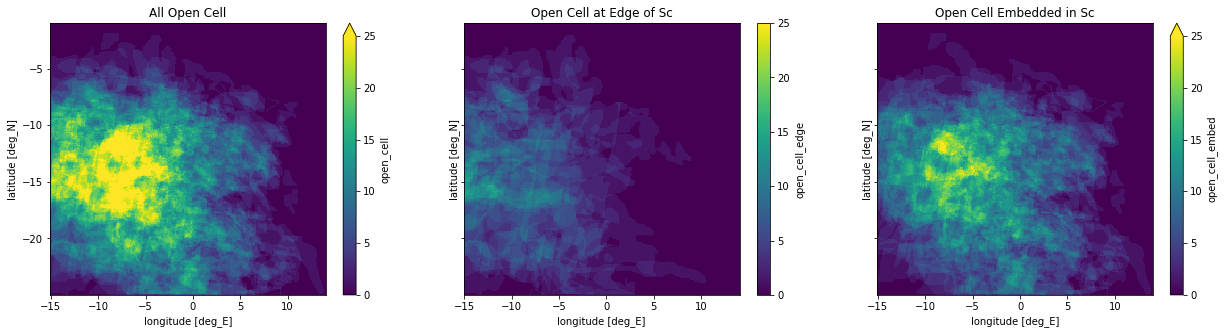

In [6]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


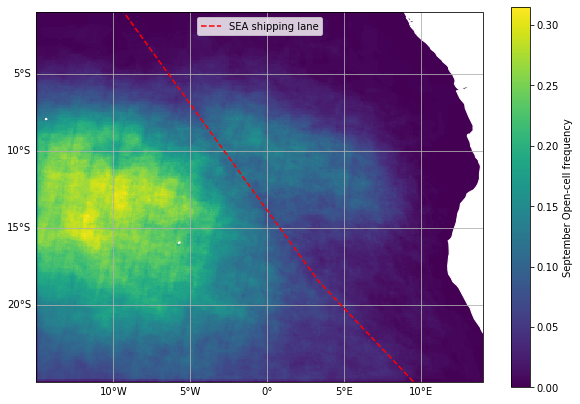

In [9]:
# ga = plt.axes(projection=ccrs.PlateCarree())
fig, ga = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(10,7))
p = ds.open_cell.mean(dim='time').plot(
                                       subplot_kws=dict(facecolor="gray"),
                                       cbar_kwargs=dict(label='September Open-cell frequency'), 
#                                        vmin=0.05, vmax=0.15,
#                                        cmap='jet',
                                       transform=ccrs.PlateCarree()
                                       )
ga.plot([18, -18], [-34, 11], color='red',  ls='--', transform=ccrs.Geodetic(), label='SEA shipping lane')
ga.set_extent([-15, 14, -25, -1], crs=ccrs.PlateCarree())
gl = ga.gridlines(draw_labels=True, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5))
ga.add_feature(cartopy.feature.LAND, facecolor='white', zorder=1)
gl.top_labels = False
gl.right_labels = False
ga.legend(loc='upper center')

# fig.savefig('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_mcc_map.png', bbox_inches='tight')


In [26]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')
ds = ds.isel({'time': slice(121,210)})

Text(0.5, 1.0, 'Open Cell Embedded in Sc')

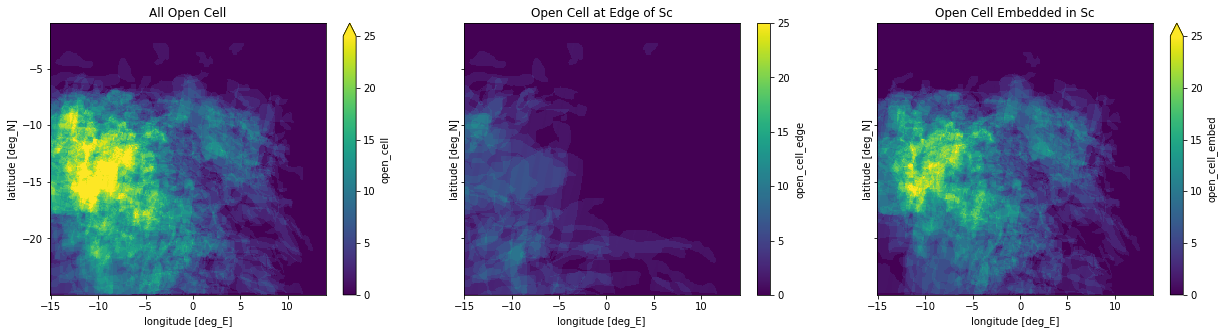

In [27]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


Text(0.5, 1.0, 'Open Cell Embedded in Sc')

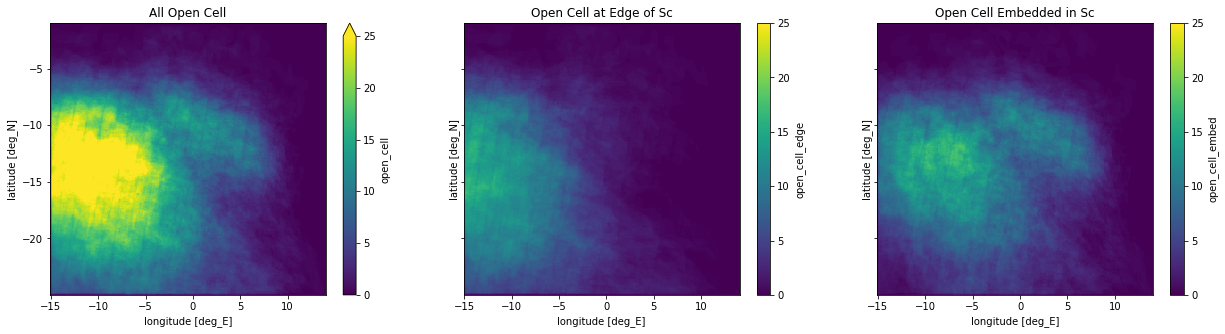

In [28]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


Text(0.5, 1.0, 'Open Cell Embedded in Sc')

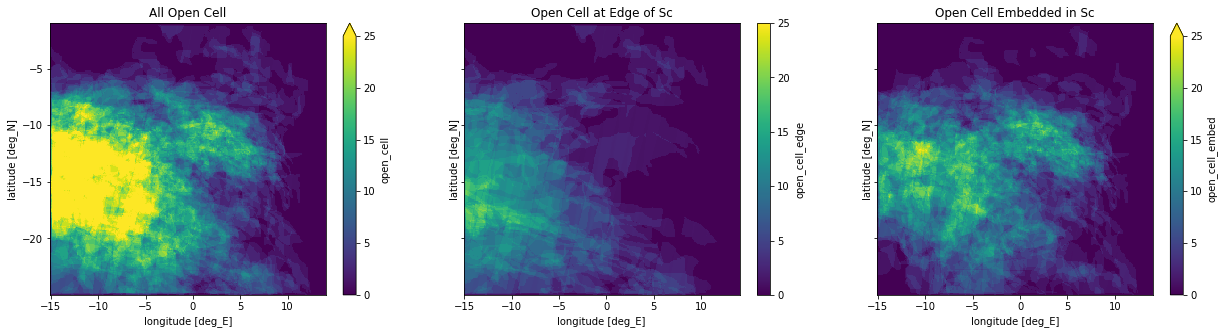

In [29]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')
ds = ds.isel({'time': slice(211,300)})
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


Text(0.5, 1.0, 'Open Cell Embedded in Sc')

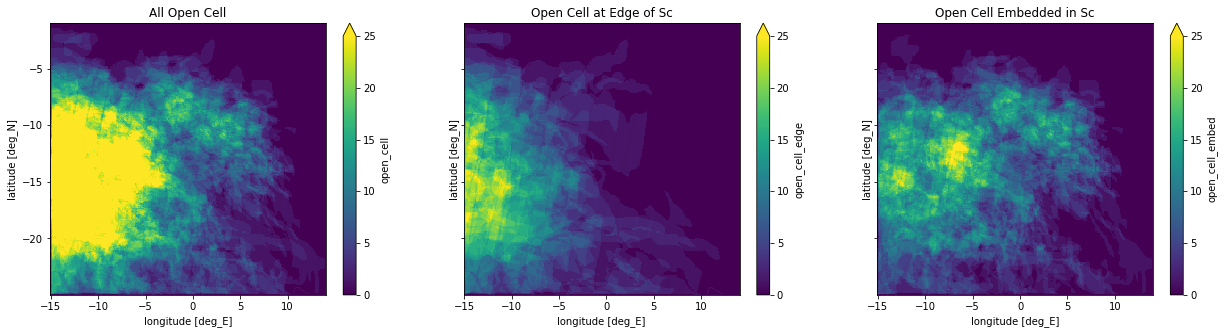

In [31]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')
ds = ds.isel({'time': slice(301,390)})
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
(ds.open_cell.mean(dim='time')*100).plot(ax=ax1, vmin=0, vmax=25)
ax1.set_title('All Open Cell')
(ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
ax2.set_title('Open Cell at Edge of Sc')
(ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
ax3.set_title('Open Cell Embedded in Sc')


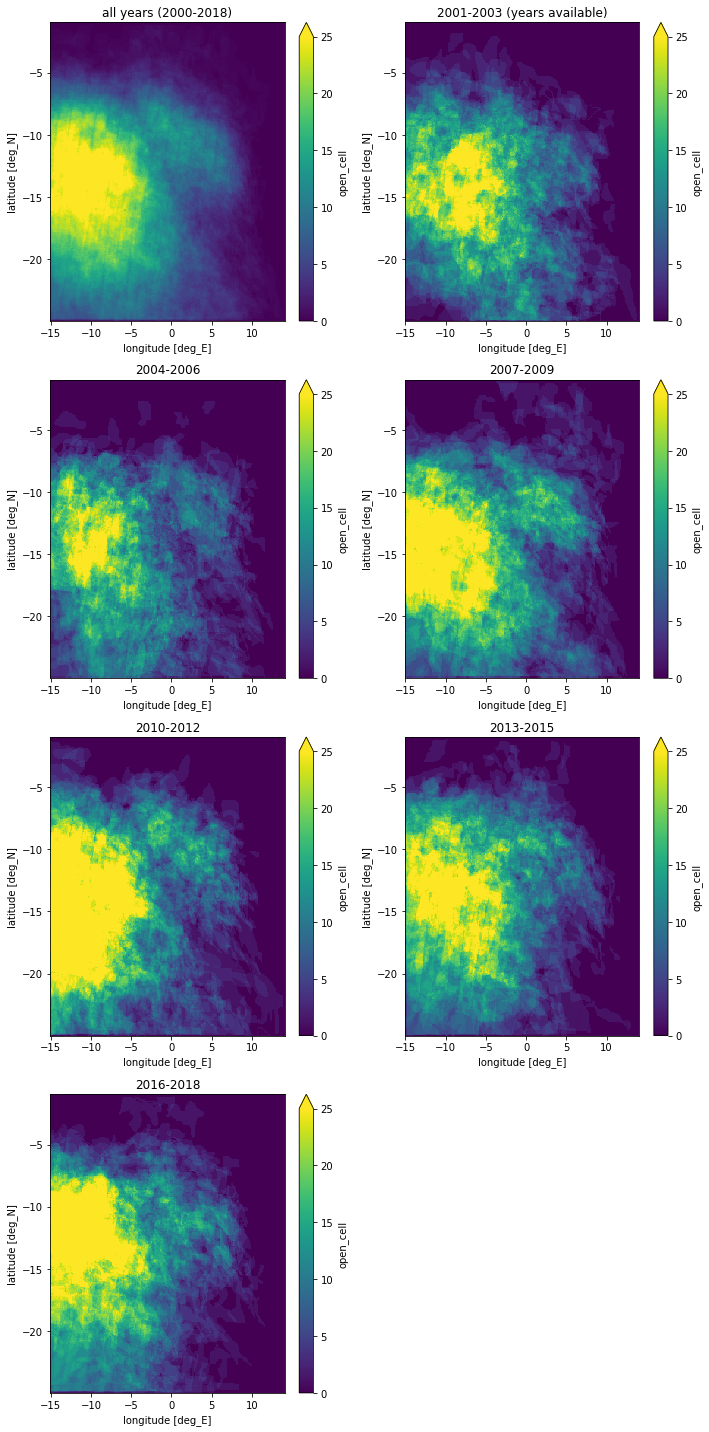

In [41]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')

titles = ['all years (2000-2018)', '2001-2003 (years available)', '2004-2006', '2007-2009', '2010-2012', '2013-2015', '2016-2018']
fig, axg = plt.subplots(figsize=(10, 20), nrows=4, ncols=2)
axl = axg.flatten()[:-1]
slices = [slice(0, -1), slice(30,120), slice(121,210), slice(211, 300), slice(301, 390), slice(391, 480),
         slice(481,570)]

for t, ax, sl in zip(titles, axl, slices):
    dsi = ds.isel({'time': sl})
#     fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
    (dsi.open_cell.mean(dim='time')*100).plot(ax=ax, vmin=0, vmax=25)
    ax.set_title(t)
#     (ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
#     ax2.set_title('Open Cell at Edge of Sc')
#     (ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
#     ax3.set_title('Open Cell Embedded in Sc')
axg.flatten()[-1].axis('off')
plt.tight_layout()

fig.savefig('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/various_years_open_mcc.png', bbox_inches='tight')

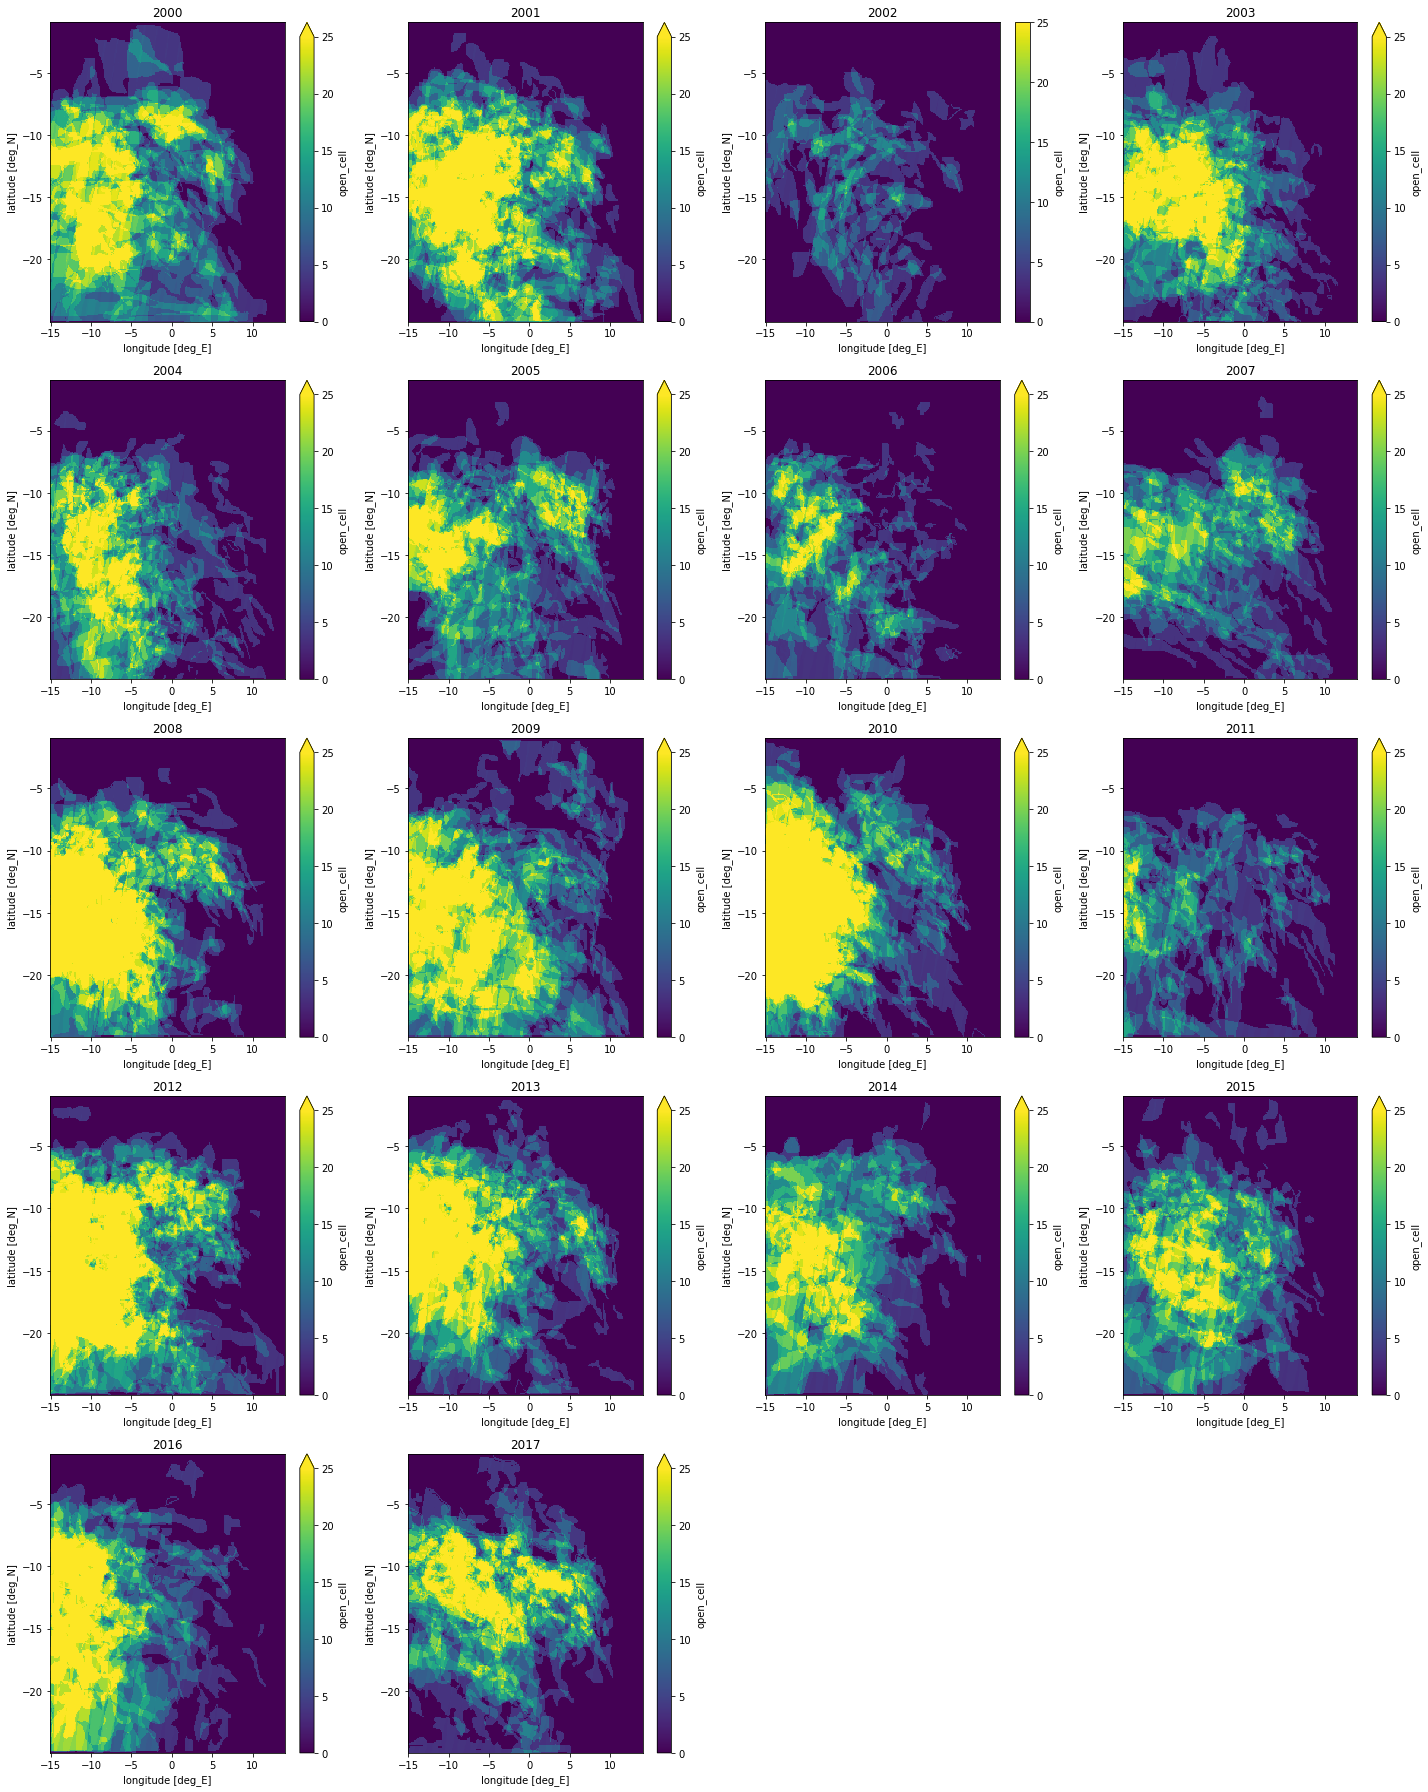

In [53]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/open_cell_climatology_modified_size_uncompressed.nc')

# titles = ['all years (2000-2018)', '2001-2003 (years available)', '2004-2006', '2007-2009', '2010-2012', '2013-2015', '2016-2018']

# slices = [slice(0, -1), slice(30,120), slice(121,210), slice(211, 300), slice(301, 390), slice(391, 480),
#          slice(481,570)]


fig, axg = plt.subplots(figsize=(20, 25), nrows=5, ncols=4)
axl = axg.flatten()[:-2]
titles = [str(2000+i) for i in range(19)]
slices = [slice(1+i*30, i*30+30) for i in range(19)]

for t, ax, sl in zip(titles, axl, slices):
    dsi = ds.isel({'time': sl})
#     fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(21, 5))
    (dsi.open_cell.mean(dim='time')*100).plot(ax=ax, vmin=0, vmax=25)
    ax.set_title(t)
#     (ds.open_cell_edge.mean(dim='time')*100).plot(ax=ax2, vmin=0, vmax=25)
#     ax2.set_title('Open Cell at Edge of Sc')
#     (ds.open_cell_embed.mean(dim='time')*100).plot(ax=ax3, vmin=0, vmax=25)
#     ax3.set_title('Open Cell Embedded in Sc')
axg.flatten()[-1].axis('off')
axg.flatten()[-2].axis('off')

plt.tight_layout()

fig.savefig('/home/disk/eos4/jkcm/Data/MEASURES/abel_data/all_years.png', bbox_inches='tight')

In [4]:
files = glob.glob(r'/home/disk/eos4/jkcm/Data/MEASURES/classified_data/model_pred*.npz')

In [6]:
datas = [np.load(i) for i in files]

In [9]:
[i for i in datas[0]]

['files', 'pred_cat', 'pred_prob']

In [22]:
plot_df = pd.read_csv(f'/home/disk/eos4/jkcm/Data/MEASURES/beta_data/unified_table_SEA_2007-2009.csv')
plot_df['named_cat'] = plot_df.apply(lambda x: short_labels[x['cat']], axis=1)

short_labels = {0: 'Closed MCC ', 1: 'Clust. Cu', 2: 'Disorg. MCC',
        3: 'Open MCC', 4: 'Solid St', 5: 'Supp. Cu'}

NameError: name 'utils' is not defined

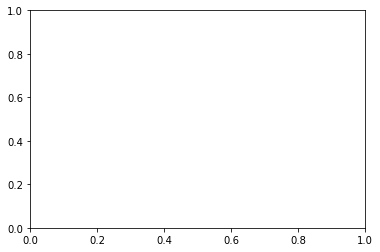

In [25]:
llr = {'lat':(-30,30), 'lon':(-45,15)}
ticks = np.logspace(-2, 0, 11)#[:-1]
bnorm = colors.BoundaryNorm(boundaries=ticks, ncolors=256)

fig, ax = plt.subplots()
b = utils.bmap(ax=ax, llr=llr)
image = b.hexbin(plot_df['lon'], plot_df['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']))
all_counts = image.get_array()+1
plt.close()

polycollections = dict()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(8,7), sharex=True, sharey=True)
axn = ax.flatten()
for cat, name  in utils.labels.items():
    axi = axn[utils.ordering.index(cat)]
    df_sub = plot_df[plot_df['cat']==cat]
    par_labs = [1, 0, 0, 0] if cat in [4, 3] else [0, 0, 0, 0]
    mer_labs = [0, 0, 0, 1] if cat in [3, 1, 5] else [0, 0, 0, 0]
    b = utils.bmap(ax=axi, llr=llr, par_labs=par_labs, mer_labs=mer_labs, merspace=30)

    image = b.hexbin(df_sub['lon'], df_sub['lat'], gridsize=30, extent=(*llr['lon'], *llr['lat']), norm=bnorm, cmap='jet')
    normed_counts = image.get_array()/all_counts
    normed_counts[all_counts==1] = np.nan
    image.set_array(normed_counts)
    
    polycollections[cat]=image
    nstr = f"n={sum(df_sub['cat']==cat)}\n({int(sum(df_sub['cat']==cat)*100/len(plot_df))}%)"
    axi.set_title(name)
    axi.annotate(nstr, xy=(0.97, 0.82), xycoords='axes fraction', fontsize=11, c='k', ha='right', bbox={'facecolor': 'w', 'edgecolor': 'k'})

# add_labels(axn)    
for i, axi in enumerate(axn):
    axi.text(0.01, 0.99, f"({chr(ord('a') + i)})", fontsize=12, backgroundcolor='w',
             horizontalalignment='left', verticalalignment='top', transform=axi.transAxes)

# plt.subplots_adjust(hspace=0.1, wspace=0.1)

cb = plt.colorbar(image, ax=axn, ticks=ticks, orientation='horizontal', pad=0.1)
cb.set_ticklabels([f"{i:0.0%}" for i in [0]+list(ticks[1:])])
cb.set_label("Relative frequency of occurrence (log scale)", fontsize=12)
# fig.savefig('/home/disk/p/jkcm/plots/measures/final/SEP_classifications_map.png', bbox_inches='tight')

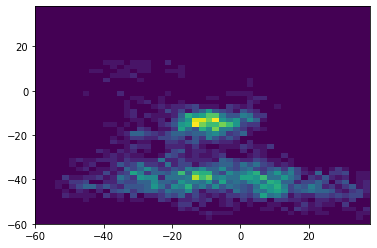

In [21]:
plt.hist2d(our_data[our_data.cat==3].lon, our_data[our_data.cat==3].lat, bins=[np.arange(-60,40, 2), np.arange(-60, 40, 2)]);